In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
#!! unzip data.zip

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [7]:
######################

In [8]:
def generate_sample(index_words_list, cnt, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                if random.randint(0, cnt[center]) <= 100:
                    yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                if random.randint(0, cnt[center]) <= 100:
                    yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1])
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]


def process_data(all_codones, batch_size, skip_window):
    flat_codones = flatten(all_codones)
    from collections import Counter
    cnt = Counter(flat_codones)
    unique_codones = list(set(flat_codones))
    unique_codones = sorted(unique_codones, key=lambda codone: -cnt[codone])
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, cnt, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen, dictionary

In [9]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen, dictionary = process_data(all_codones, BATCH_SIZE, SKIP_WINDOW)


In [10]:
######################

In [11]:
class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_embedding(self):
        with tf.name_scope("embed"):
            self.embed_matrix = tf.Variable(tf.random_uniform([self.vocab_size,
                                                               self.embed_size], -1.0, 1.0),
                                            name='embed_matrix')
                
    def _create_loss(self):
        with tf.device('/cpu:0'):
            with tf.name_scope("loss"):
                embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

                # construct variables for NCE loss
                self.hidden_weight1 = tf.Variable(tf.truncated_normal([self.embed_size, 100],
                                                               stddev=1.0 / (self.embed_size ** 0.5)),
                                           name='hidden_weight')
                self.hidden_bias1 = tf.Variable(tf.zeros([100]), name='hidden_bias')
                self.encode = tf.nn.tanh(tf.matmul(embed, self.hidden_weight1) + self.hidden_bias1)

                hidden_weight2 = tf.Variable(tf.truncated_normal([100, 100],
                                                               stddev=1.0 / (100 ** 0.5)),
                                           name='hidden_weight')
                hidden_bias2 = tf.Variable(tf.zeros([100]), name='hidden_bias')
                fc_output2 = tf.nn.tanh(tf.matmul(self.encode, hidden_weight2) + hidden_bias2)
                
                nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, 100],
                                                             stddev=1.0 / (self.vocab_size ** 0.5)),
                                         name='nce_weight')
                nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

                # define loss function to be NCE loss function
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                         biases=nce_bias,
                                                         labels=self.target_words,
                                                         inputs=fc_output2,
                                                         num_sampled=self.num_sampled,
                                                         num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss,
                                                                                 global_step=self.global_step)

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def get_embed(self):
        self.encode = tf.nn.sigmoid(tf.matmul(self.embed_matrix, self.hidden_weight1) + self.hidden_bias1)
        return self.encode
            
    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [12]:
VOCAB_SIZE = 9424
EMBED_SIZE = 150  # dimension of the word embedding vectors
NUM_SAMPLED = 8  # Number of negative examples to sample.
LEARNING_RATE = 0.8
NUM_TRAIN_STEPS = 10000
SKIP_STEP = 2000

model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
model.build_graph()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [13]:
######################

In [14]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [15]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    saver = tf.train.Saver()  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    make_dir('checkpoints')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(tf.global_variables_initializer())
#         ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
# #        if that checkpoint exists, restore from checkpoint
#         if ckpt and ckpt.model_checkpoint_path:
#             saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op],
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run([model.get_embed()], feed_dict)
        return final_embed_matrix

In [16]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999:  18.5
Average loss at step 3999:  11.9
Average loss at step 5999:   9.7
Average loss at step 7999:   8.4
Average loss at step 9999:   7.1


In [17]:
######################

In [18]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix[0])

In [19]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0        x1 codone
0  6.364720  0.918162    AAA
1  3.992669  0.573389    LLL
2  4.047377  6.348021    ALA
3  4.542677 -1.271059    LAA
4 -3.543118 -6.549675    AAL

In [20]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

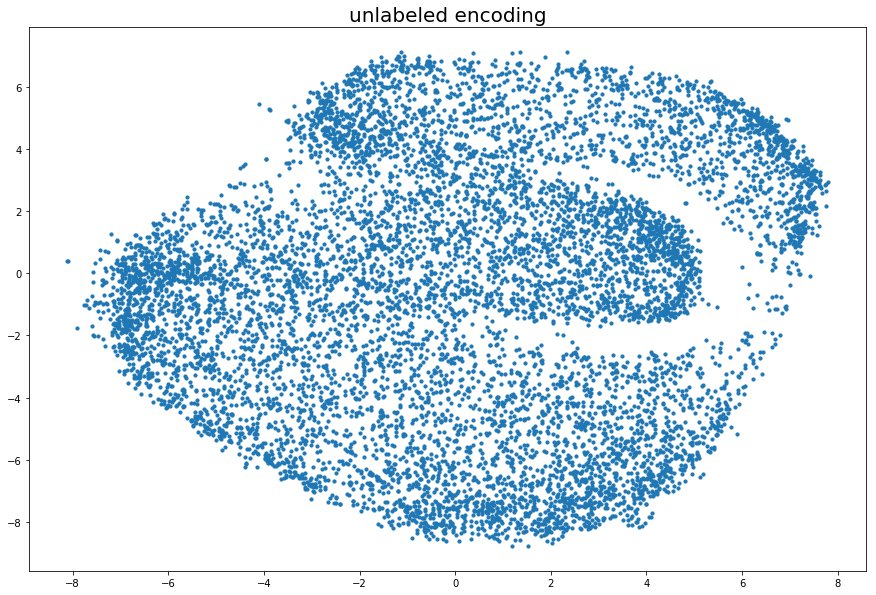

In [21]:
plot_tsne_df(tsne_df)

In [22]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [23]:
######################

In [24]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [25]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [26]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume
0  APC        0.900000   90.445333        14.666667  103.266667
1  GWP       -0.966667  113.458800        18.000000  133.533333
2  PPC       -0.233333   99.124433        16.000000  111.300000
3  KSI       -0.066667  109.469067        20.000000  141.433333
4  TXG       -0.550000   79.077600        13.500000   88.100000

In [27]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume        x0  \
0  APC        0.900000   90.445333        14.666667  103.266667 -4.247075   
1  GWP       -0.966667  113.458800        18.000000  133.533333 -0.649256   
2  PPC       -0.233333   99.124433        16.000000  111.300000 -2.116666   
3  KSI       -0.066667  109.469067        20.000000  141.433333  0.189015   
4  TXG       -0.550000   79.077600        13.500000   88.100000 -5.914330   

         x1  
0 -4.990238  
1  4.969749  
2  1.163254  
3  6.640073  
4 -2.085110

In [28]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

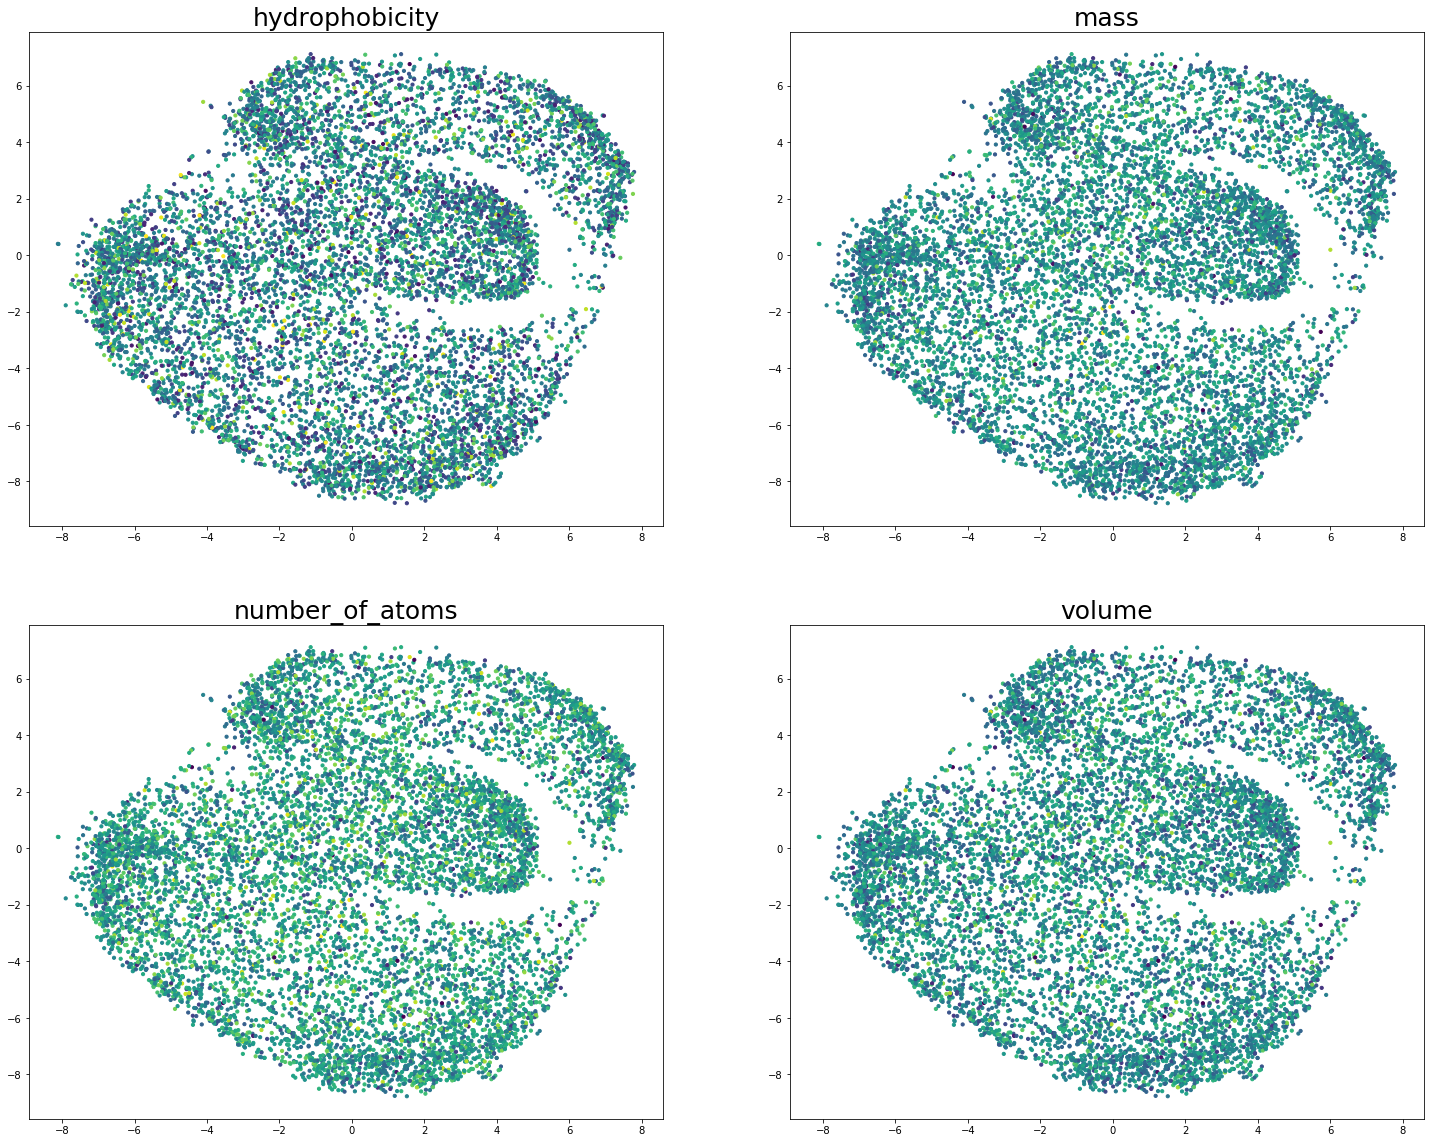

In [29]:
plot_embedding_properties(final_df)

In [32]:
######################

In [29]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

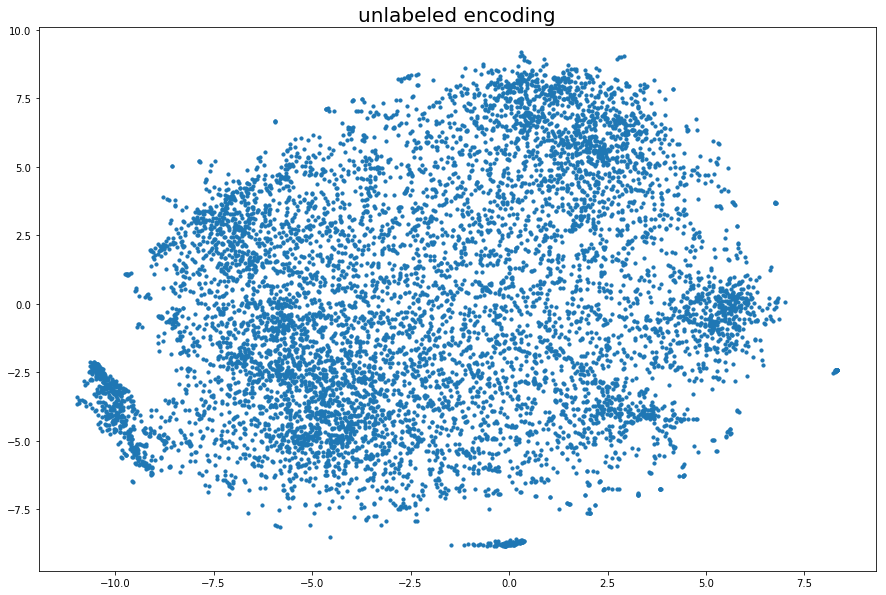

In [30]:
plot_tsne_df(gensim_tsne_df)

In [31]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

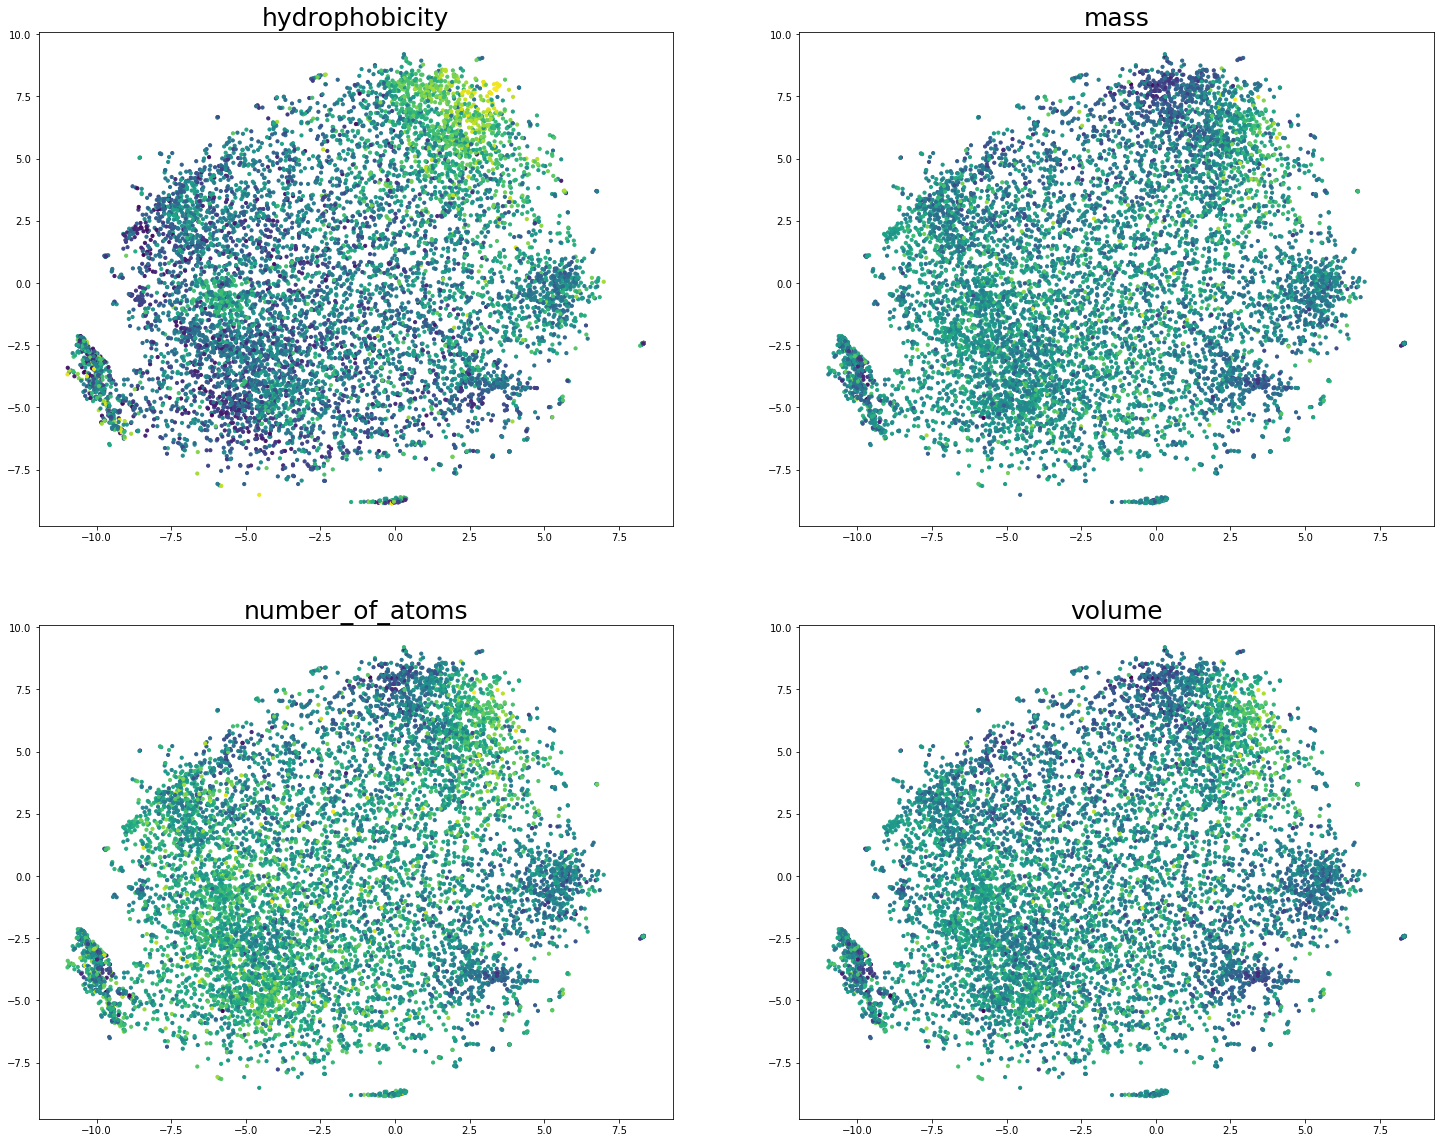

In [32]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/